In [3]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

%matplotlib inline

In [49]:
if not '../../data/osha/osha_norm_naics.csv':
    with zipfile.ZipFile('../../data/osha/osha_norm_naics.zip','r') as zfile:
        zfile.extractall('../../data/osha')
osha = pd.read_csv('../../data/osha/osha_norm_naics.csv', dtype={'naics_code':str, 'sic_code':str},
                  na_values = ["", " ","NaN", "nan", "NA", "na", "Na"])
osha = osha[['date_sampled','inspection_number', 'establishment_name', 'preferred_name','naics_unified', 'sector_name', 'subsector_name',
             'industry_group_name', 'conc_mgm3']]  # keep only cols we need
osha['date_sampled'] = osha['date_sampled'].str.slice(0,4)
osha = osha[~osha['sector_name'].isin(["Undefined/Multiple"])]
osha = osha.drop(osha[osha['conc_mgm3']>10000].index)
osha = osha.dropna(subset=['conc_mgm3', 'sector_name'])
#osha['sector_enc'] = osha['sector_name'].astype('category').cat.codes
#osha['subsector_enc'] = osha['subsector_name'].astype('category').cat.codes
#osha['industry_group_enc'] = osha['industry_group_name'].astype('category').cat.codes
osha['detected'] = np.where(osha['conc_mgm3'] > 0, 1, 0)

In [50]:
osha = osha.groupby(['inspection_number', 'establishment_name', 'preferred_name','naics_unified', 'sector_name',
                     'subsector_name', 'industry_group_name'], as_index=False).max(numeric_only=True)
osha.head(6)

,inspection_number,establishment_name,preferred_name,naics_unified,sector_name,subsector_name,industry_group_name,date_sampled,conc_mgm3,detected
0,29067,"GARMAT USA, INC.",Iron oxide,332322,Manufacturing,Fabricated Metal Product Manufacturing,Architectural and Structural Metals Manufacturing,2011,1.959734,1
1,29206,Polar Corporation,Iron oxide,811310,Other Services,Repair and Maintenance,Commercial and Industrial Machinery and Equipm...,2011,12.966245,1
2,29251,"Jobsite, Inc.",Iron oxide,333517,Manufacturing,Machinery Manufacturing,Metalworking Machinery Manufacturing,2011,0.519814,1
3,29479,"TIC, The Industrial Company",Iron oxide,236210,Construction,Construction of Buildings,Nonresidential Building Construction,2011,0.080790,1
4,63156,Nomad Global Communication Solutions,Iron oxide,334290,Manufacturing,Computer and Electronic Product Manufacturing,Communications Equipment Manufacturing,2011,3.093908,1
5,63259,"PRECISION PLATING COMPANY, INC.",Iron oxide,332813,Manufacturing,Fabricated Metal Product Manufacturing,"Coating, Engraving, Heat Treating, and Allied ...",2011,0.000000,0


In [51]:
len(osha)

233975

Check for strong correlations in the opera predictors

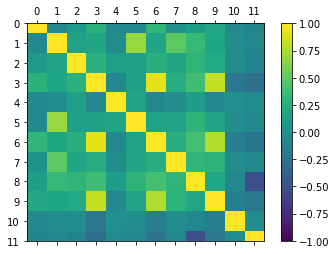

In [55]:
from sklearn.preprocessing import scale

chem_data = pd.read_csv('../../data/osha/osha_chem_properties.csv')
chem_data[chem_data.columns[8:]] = chem_data[chem_data.columns[8:]].apply(pd.to_numeric,errors='coerce')
chem_data.columns = [x.lower() for x in chem_data.columns]
opera_cols =  chem_data.columns[10:22]
opera = chem_data[opera_cols].copy()
opera['preferred_name'] = chem_data['preferred_name']
opera_s = opera.copy()
opera_s[opera_cols] =  scale(opera_s[opera_cols])  # center and scale opera predictors

correlations = opera_s.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,12,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.show()

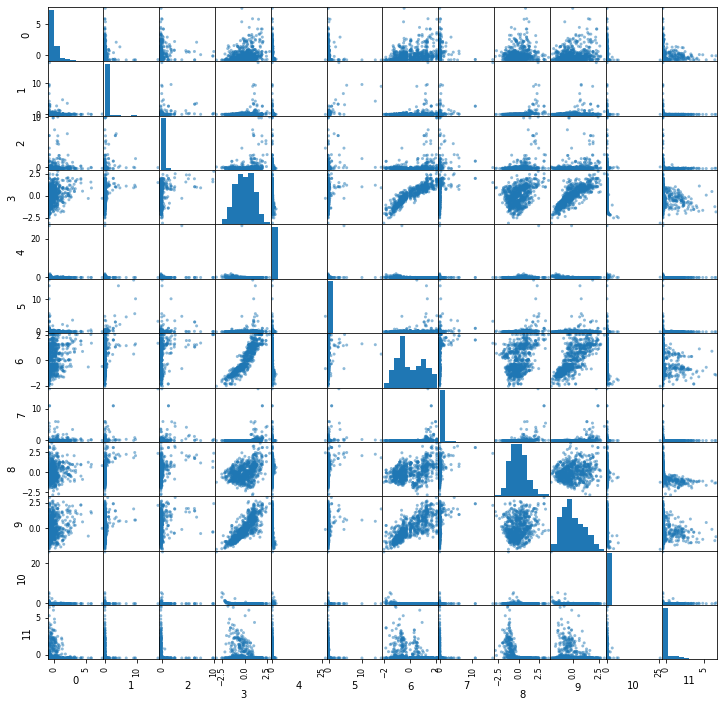

In [7]:
from pandas.plotting import scatter_matrix
opera_s_plot = opera_s.copy()
opera_s_plot.columns = np.arange(0,13,1)
scatter_matrix(opera_s_plot, figsize=(12,12))
plt.show()

Boiling point, melting point and octanol-air partition coefficient are highly positively correlated. We can likely drop two of the three.

In [56]:
opera_s = opera_s.drop(columns=['octanol_air_partition_coeff_logkoa_opera_pred','melting_point_degc_opera_pred']) # drop highly correlated predictors
opera_cols = opera_s.columns.tolist()
opera_cols.remove('preferred_name')

chem_osha = osha.merge(opera_s, left_on='preferred_name', right_on='preferred_name')
chem_osha = chem_osha.dropna(subset=['henrys_law_atm-m3/mole_opera_pred'])  # drop rows missing opera predictions
osha_enc = chem_osha.dropna(subset=['subsector_name'])
osha_enc = osha_enc.drop(osha_enc[osha_enc['subsector_name']=='Undefined/Multiple'].index)
osha_enc['sector_enc'] = osha_enc['sector_name'].astype('category').cat.codes  # re-factor
osha_enc['subsector_enc'] = osha_enc ['subsector_name'].astype('category').cat.codes  # re-factor
len(osha_enc.sector_name.value_counts()), len(osha_enc.subsector_name.value_counts())

(20, 91)

In [89]:
sector_index = osha_enc.groupby(['sector_name']).all().reset_index().reset_index()[['index', 'sector_name']]
sector_subsector_index = osha_enc.groupby(['sector_name', 'subsector_name']).all().reset_index().reset_index()[['index', 'sector_name', 'subsector_name']]
sector_subsector_indexes_df = pd.merge(sector_index, sector_subsector_index, how='inner', on='sector_name', suffixes=('_s', '_ss'))
indexed_osha = pd.merge(osha_enc, sector_subsector_indexes_df, how = 'inner', on=['sector_name', 'subsector_name']).reset_index()

sector_indexes = sector_index['index'].values
sector_count = len(sector_indexes)
sector_subsector_indexes = sector_subsector_indexes_df['index_ss'].values
sector_subsector_count = len(sector_subsector_indexes)

#from sklearn.model_selection import train_test_split
#indexed_osha, indexed_osha_test = train_test_split(indexed_osha, test_size=0.1, random_state=5757)  # training/test dataset split completely random

indexed_osha_test = indexed_osha[indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015'])]  # training/test dataset split by year
indexed_osha = indexed_osha[~(indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015']))]

In [90]:
len(indexed_osha_test)/(len(indexed_osha)+len(indexed_osha_test))

0.05891482894651749

In [120]:
preds = indexed_osha[opera_cols]
npreds = len(opera_cols)

from theano import tensor as tt
from theano import shared

detected_shared = shared(indexed_osha.detected.values)
preds_shared = shared(preds.as_matrix())
index_s_shared = shared(indexed_osha.index_s.values)
index_ss_shared = shared(indexed_osha.index_ss.values)


with pm.Model() as hierarchical_logistic_osha_2:
    
    global_mu = pm.StudentT('global_mu', nu=5, mu=0, sigma=10)
    global_lam = pm.HalfCauchy('global_lam',beta=25)
    
    sector_int_mu = pm.StudentT("sector_int_mu",nu = 5, mu = global_mu, sigma=global_lam, shape=sector_count)

    sigma_subsector_int = pm.HalfCauchy('sigma_subsector_int',beta=25)
    
    subsector_int = pm.StudentT("subsector_int", 1, mu=sector_int_mu[sector_subsector_indexes_df['index_s']],
                          sigma=sigma_subsector_int, shape=sector_subsector_count)
    beta = pm.StudentT('beta',nu=5,mu=0,sigma=2.5, shape=(npreds))  # recommended by stan wiki, Gelman et al 2008
    μ = subsector_int[index_ss_shared] + tt.dot(preds_shared,beta)
    
    θ = pm.Deterministic('θ',pm.math.sigmoid(μ))
    
    like = pm.Bernoulli(
        'likelihood',
        p = θ,
        observed=detected_shared
    )

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


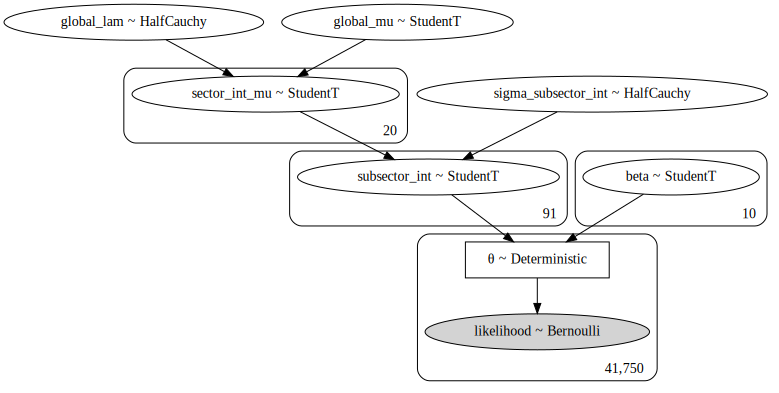

In [11]:
from pymc3 import model_to_graphviz

model_to_graphviz(hierarchical_logistic_osha_2)

In [121]:
with hierarchical_logistic_osha_2:
    fr_advi = pm.FullRankADVI()
tracker = pm.callbacks.Tracker(
    mean=fr_advi.approx.mean.eval,  # callable that returns mean
    std=fr_advi.approx.std.eval  # callable that returns std
)
fit = fr_advi.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])
#fit = fr_advi.fit(50000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])


  0%|          | 0/100000 [00:00<?, ?it/s]/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Average Loss = 26,407: 100%|██████████| 100000/100000 [13:12<00:00, 126.20it/s]
Finished [100%]: Average Loss = 26,407


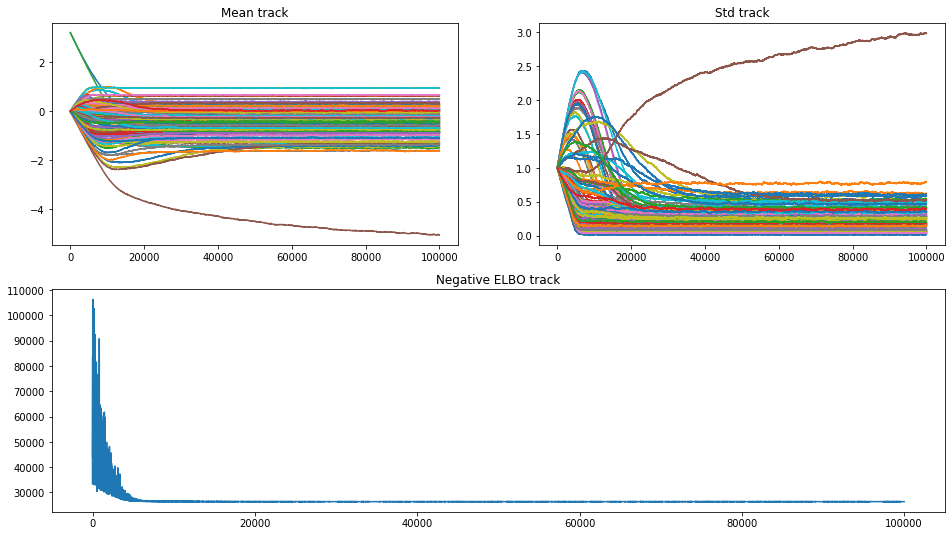

In [93]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(fit.hist)
hist_ax.set_title('Negative ELBO track');

<Figure size 432x1152 with 0 Axes>

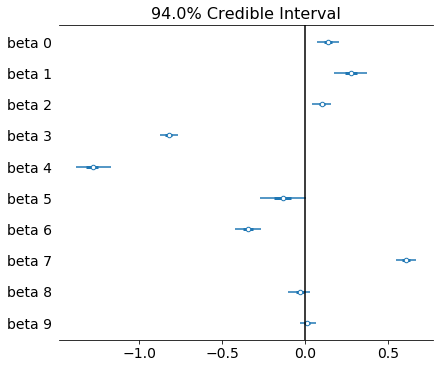

In [122]:
from pymc3 import forestplot
plt.figure(figsize=(6,16))
#forestplot(mean_field.sample(1000), kind='ridgeplot', colors='white', var_names=['beta']);
forestplot(fit.sample(1000), var_names=['beta']);
plt.axvline(x=0, color='black')

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


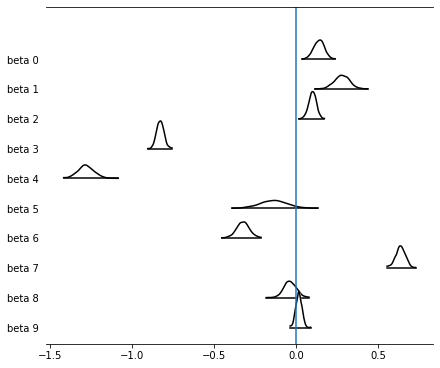

In [15]:
fig, axes = forestplot(fit.sample(1000), kind='ridgeplot', var_names=['beta'], ridgeplot_overlap=3, colors='white');
plt.axvline(x=0)

In [16]:
for i, var in enumerate(opera_cols):
    print('beta {}: {}'.format(i,var))

beta 0: atmospheric_hydroxylation_rate_(aoh)_cm3/molecule*sec_opera_pred
beta 1: bioconcentration_factor_opera_pred
beta 2: biodegradation_half_life_days_days_opera_pred
beta 3: boiling_point_degc_opera_pred
beta 4: henrys_law_atm-m3/mole_opera_pred
beta 5: opera_km_days_opera_pred
beta 6: soil_adsorption_coefficient_koc_l/kg_opera_pred
beta 7: octanol_water_partition_logp_opera_pred
beta 8: vapor_pressure_mmhg_opera_pred
beta 9: water_solubility_mol/l_opera_pred


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


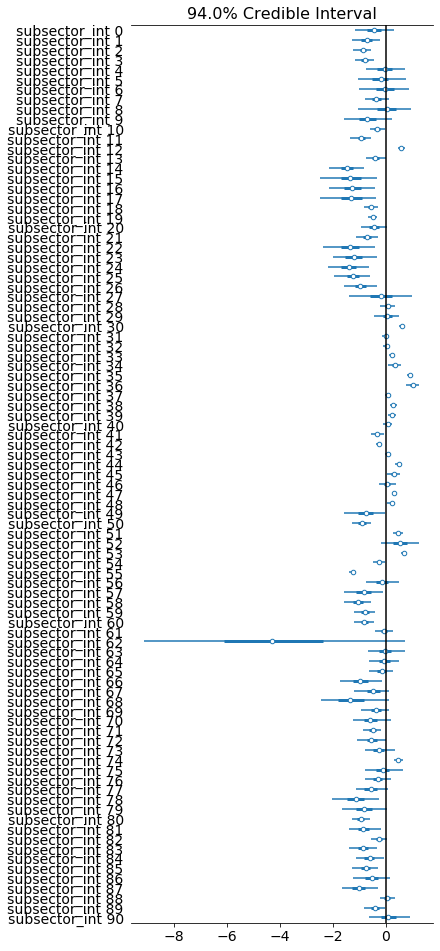

In [17]:
forestplot(fit.sample(1000), var_names=['subsector_int'])
plt.axvline(x=0, color='black')

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


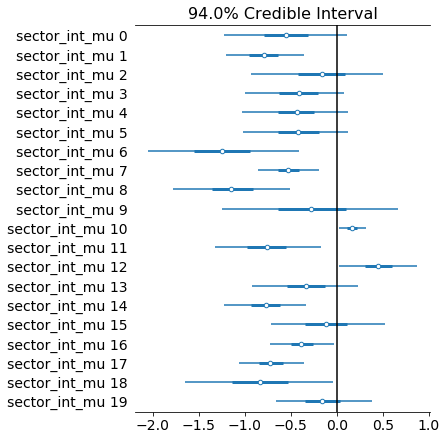

In [18]:
forestplot(fit.sample(1000), var_names=['sector_int_mu']);
plt.axvline(x=0, color='black')

In [19]:
sector_index

,index,sector_name
0,0,Accomodation and Food Services
1,1,Administrative and Support and Waste Managemen...
2,2,"Agriculture, Forestry, Fishing and Hunting"
3,3,"Arts, Entertainment, and Recreation"
4,4,Construction
5,5,Educational Services
6,6,Finance and Insurance
7,7,Health Care and Social Assistance
8,8,Information
9,9,Management of Companies and Enterprises


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4e3b41390>,
      dtype=object)

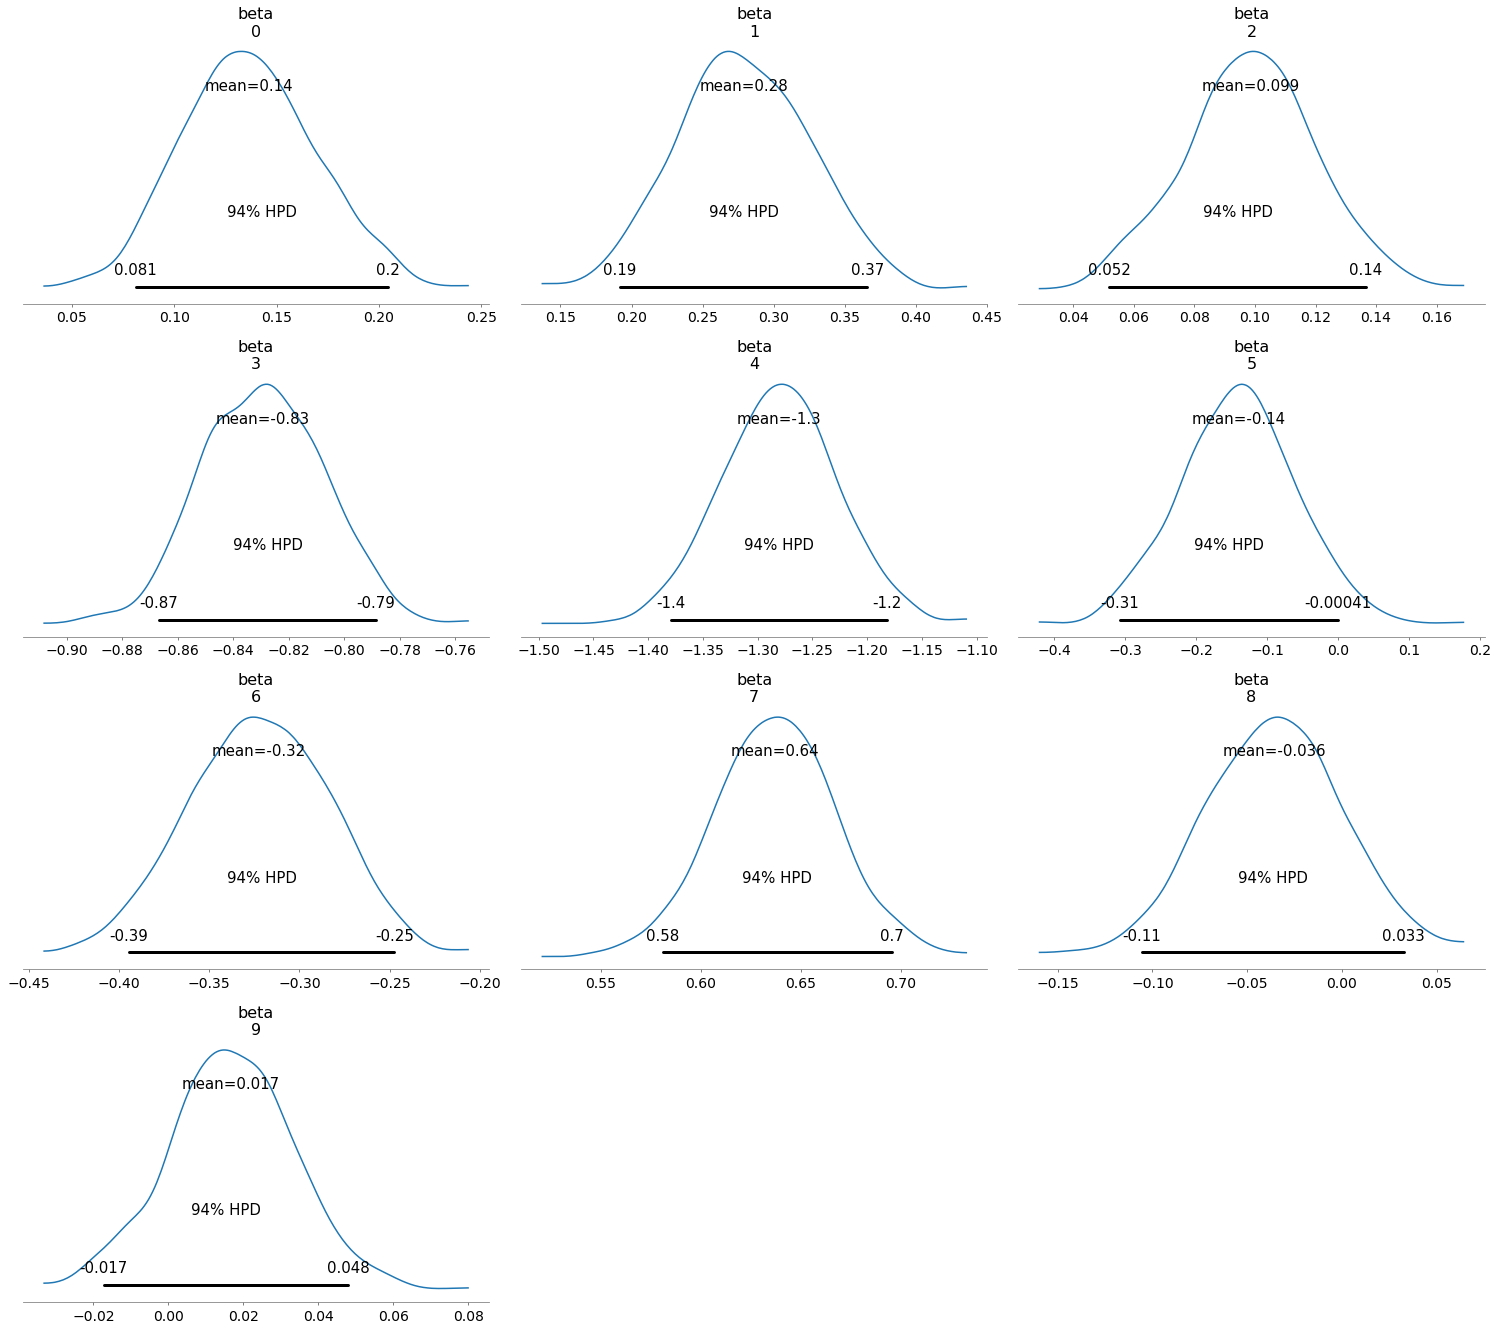

In [20]:
pm.plot_posterior(fit.sample(1000), var_names=['beta'])

In [21]:
for i, var in enumerate(opera_cols):
    print('beta {}: {}'.format(i,var))

beta 0: atmospheric_hydroxylation_rate_(aoh)_cm3/molecule*sec_opera_pred
beta 1: bioconcentration_factor_opera_pred
beta 2: biodegradation_half_life_days_days_opera_pred
beta 3: boiling_point_degc_opera_pred
beta 4: henrys_law_atm-m3/mole_opera_pred
beta 5: opera_km_days_opera_pred
beta 6: soil_adsorption_coefficient_koc_l/kg_opera_pred
beta 7: octanol_water_partition_logp_opera_pred
beta 8: vapor_pressure_mmhg_opera_pred
beta 9: water_solubility_mol/l_opera_pred


### Find an exact solution with Hamiltonian MC (takes much longer)

In [22]:
#with hierarchical_logistic_osha_2:
#    hmc = pm.sample(4000)

In [23]:
#pm.gelman_rubin(hmc)

In [24]:
#pm.traceplot(hmc, var_names=['subsector_int']);

In [25]:
#pm.traceplot(hmc,var_names = ['beta'])

In [26]:
#pm.forestplot(hmc, var_names = ['beta','sector_int_mu', 'subsector_int'], combined=True)

## Posterior predictive checks

#### Average across 500 sets of probablistic predictions

In [123]:
ppc = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=hierarchical_logistic_osha_2)
avg_predictions = np.where(ppc['likelihood'].mean(axis=0) >= 0.5, 1, 0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:07<00:00, 66.81it/s]


#### Classification accuracy metrics

In [124]:
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
accuracy = accuracy_score(avg_predictions, indexed_osha['detected'])
auc = roc_auc_score(avg_predictions, indexed_osha['detected'])
print('Training classification accuracy: {:.2f}'.format(accuracy))
print('Training ROC area under the curve: {:.2f}'.format(auc))

Training classification accuracy: 0.69
Training ROC area under the curve: 0.68


In [119]:
null_predictions = np.where(np.random.uniform(size=len(indexed_osha['detected'])) >
                                        indexed_osha['detected'].mean(),1,0)
null_accuracy = accuracy_score(null_predictions,indexed_osha['detected'])
null_auc = roc_auc_score(null_predictions, indexed_osha['detected'])
print('Null model training classification accuracy: {:.2f}'.format(null_accuracy))
print('Null model training ROC area under the curve: {:.2f}'.format(null_auc))

Null model training classification accuracy: 0.47
Null model training ROC area under the curve: 0.50


#### Actual vs predicted subsector detection frequency

In [97]:
subsector_probs = indexed_osha[['detected', 'index_ss']].copy()
subsector_probs['prob_predicted'] = avg_predictions
subsector_probs = subsector_probs.groupby('index_ss').mean()
subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_probs['detected'], subsector_probs['prob_predicted'])[0,1]

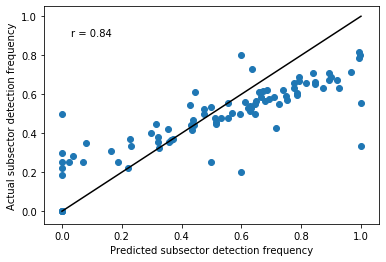

In [98]:
plt.scatter( subsector_probs['prob_predicted'], subsector_probs['detected'])
plt.plot([0, 1], [0, 1], color='black')
plt.xlabel('Predicted subsector detection frequency')
plt.ylabel('Actual subsector detection frequency')
plt.text(0.03, 0.9, 'r = {:.2f}'.format(r))
plt.show()

#### Test set accuracy

In [125]:
preds_test = indexed_osha_test[opera_cols]
detected_shared.set_value(indexed_osha_test.detected.values)
preds_shared.set_value(preds_test.as_matrix())
index_s_shared.set_value(indexed_osha_test.index_s.values)
index_ss_shared.set_value(indexed_osha_test.index_ss.values)

ppc_test = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=hierarchical_logistic_osha_2)
avg_predictions_test = np.where(ppc_test['likelihood'].mean(axis=0) >= 0.5, 1, 0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:05<00:00, 92.77it/s]


In [126]:
accuracy = accuracy_score(avg_predictions_test, indexed_osha_test['detected'])
null_predictions_test = np.where(np.random.uniform(size=len(indexed_osha_test['detected'])) >
                                        indexed_osha_test['detected'].mean(),1,0)
null_accuracy = accuracy_score(null_predictions_test,indexed_osha_test['detected'])
auc = roc_auc_score(avg_predictions_test, indexed_osha_test['detected'])
null_auc = roc_auc_score(null_predictions_test, indexed_osha_test['detected'])
print('Test classification accuracy: {:.2f}'.format(accuracy))
print('Null model test classification accuracy: {:.2f}'.format(null_accuracy))
print('Test ROC area under the curve: {:.2f}'.format(auc))
print('Null model test ROC area under the curve: {:.2f}'.format(null_auc))


Test classification accuracy: 0.68
Null model test classification accuracy: 0.45
Test ROC area under the curve: 0.66
Null model test ROC area under the curve: 0.49


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


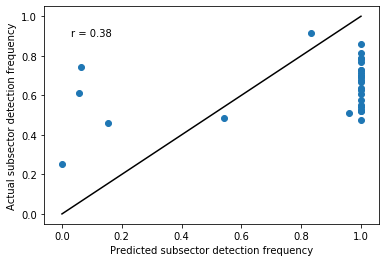

In [109]:
subsector_probs_test = indexed_osha_test[['detected', 'index_ss']].copy()
subsector_probs_test['prob_predicted'] = avg_predictions_test
subsector_probs_test = subsector_probs_test.groupby('index_ss').mean()
subsector_counts_test = indexed_osha_test['index_ss'].value_counts()
subsector_probs_test = subsector_probs_test[subsector_counts_test > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_probs_test['detected'], subsector_probs_test['prob_predicted'])[0,1]

plt.scatter(subsector_probs_test['prob_predicted'], subsector_probs_test['detected'])
plt.plot([0, 1], [0, 1], color='black')
plt.xlabel('Predicted subsector detection frequency')
plt.ylabel('Actual subsector detection frequency')
plt.text(0.03, 0.9, 'r = {:.2f}'.format(r))
plt.show()